# Adversarial Search: Playing "Mean" Connect 4


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play "Mean" Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

> **The mean part:** This game has an additional rule. Every time it is a player's turn, the player can decide to instead of playing a new disk, take a bottom row disk of the opponent and place it in any column. All disks above the removed disk will fall down one position. Note that a player can only move an _opponent's disc_ that is in the _bottom row_ of the board.

Note that normal [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

In [22]:
# Your code/answer goes here.
# ...existing code...
import numpy as np

def actions(board, player):
    """Trả về list các hành động hợp lệ trên board cho player.
    Hành động: ("drop", col) hoặc ("steal", from_col, to_col).
    board: numpy array shape (rows, cols), values in {0,1,-1}.
    """
    rows, cols = board.shape
    acts = []
    # drop actions: cột không đầy
    for c in range(cols):
        if board[0, c] == 0:
            acts.append(("drop", c))
    # steal actions: bottom row có đĩa của opponent
    opp = -player
    for c_from in range(cols):
        if board[-1, c_from] == opp:
            # destination columns that have space
            for c_to in range(cols):
                if board[0, c_to] == 0:
                    acts.append(("steal", c_from, c_to))
    return acts

def result(board, action, player):
    """Áp dụng action lên board và trả về board mới (không thay đổi board gốc)."""
    b = board.copy()
    rows, cols = b.shape
    if action[0] == "drop":
        _, c = action
        if b[0, c] != 0:
            raise Exception(f"Illegal drop: column {c} is full")
        for r in range(rows-1, -1, -1):
            if b[r, c] == 0:
                b[r, c] = player
                break
    elif action[0] == "steal":
        _, c_from, c_to = action
        opp = -player
        if b[-1, c_from] != opp:
            raise Exception(f"Illegal steal: bottom of column {c_from} is not opponent's disk")
        if b[0, c_to] != 0:
            raise Exception(f"Illegal steal: destination column {c_to} is full")
        # remove bottom disk at c_from and shift column down
        for r in range(rows-1, 0, -1):
            b[r, c_from] = b[r-1, c_from]
        b[0, c_from] = 0
        # place the stolen disk (its value remains opponent's)
        for r in range(rows-1, -1, -1):
            if b[r, c_to] == 0:
                b[r, c_to] = opp
                break
    else:
        raise Exception(f"Unknown action type: {action[0]}")
    return b

def check_four_in_a_row(board, connect=4):
    """Kiểm tra người thắng: trả về 1 nếu player 1 thắng, -1 nếu player -1 thắng, 0 nếu chưa có."""
    rows, cols = board.shape
    directions = [(0,1), (1,0), (1,1), (1,-1)]  # horiz, vert, diag down-right, diag down-left
    for r in range(rows):
        for c in range(cols):
            val = board[r, c]
            if val == 0:
                continue
            for dr, dc in directions:
                cnt = 1
                rr, cc = r, c
                for _ in range(1, connect):
                    rr += dr; cc += dc
                    if 0 <= rr < rows and 0 <= cc < cols and board[rr, cc] == val:
                        cnt += 1
                    else:
                        break
                if cnt >= connect:
                    return int(val)
    return 0

def terminal(board, connect=4):
    """Trả về (is_terminal, winner). winner: 1, -1 cho thắng, 0 cho hòa, None nếu chưa kết thúc."""
    winner = check_four_in_a_row(board, connect=connect)
    if winner != 0:
        return True, winner
    if not (board == 0).any():
        return True, 0
    return False, None

def utility(board, player, connect=4):
    """Utility cho player: +1 thắng, -1 thua, 0 hòa. None nếu chưa terminal."""
    is_term, winner = terminal(board, connect=connect)
    if not is_term:
        return None
    if winner == 0:
        return 0
    return 1 if winner == player else -1
# ...existing code...

How big is the state space? Give an estimate and explain it.

In [23]:
# Your code/ answer goes here.
# ...existing code...
import math

# Task1 - Cell 1: Ước lượng kích thước không gian trạng thái
rows, cols = 6, 7  # mặc định board chuẩn
states_tho = 3 ** (rows * cols)
print(f"Board {rows}x{cols}")
print("Số cấu hình thô (mỗi ô 3 trạng thái): 3^(rows*cols) =", states_tho)
print("≈ {:.3e}".format(states_tho))
print("log10(3^(rows*cols)) = {:.3f}".format(math.log10(states_tho)))

# Giải thích ngắn:
print("\nGiải thích: mỗi ô có 3 trạng thái (empty/1/-1) ⇒ thô = 3^(rows*cols).")
print("Số trạng thái hợp lệ (theo quy tắc rơi) nhỏ hơn nhưng cùng bậc lớn — quá lớn để duyệt toàn bộ.")

Board 6x7
Số cấu hình thô (mỗi ô 3 trạng thái): 3^(rows*cols) = 109418989131512359209
≈ 1.094e+20
log10(3^(rows*cols)) = 20.039

Giải thích: mỗi ô có 3 trạng thái (empty/1/-1) ⇒ thô = 3^(rows*cols).
Số trạng thái hợp lệ (theo quy tắc rơi) nhỏ hơn nhưng cùng bậc lớn — quá lớn để duyệt toàn bộ.


How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [24]:
# Your code/ answer goes here.
# ...existing code...
import math

# Task1 - Cell 2: Ước lượng kích thước cây trò chơi (minimax)
rows, cols = 6, 7
d_max = rows * cols

# branching factor ước lượng: tối thiểu ~ số cột (drop only), tối đa thêm tùy chọn steal (~+cols)
b_min = cols
b_max = cols * 2
b_example = 10  # ví dụ minh họa trung bình

print(f"Độ sâu tối đa d ≤ rows*cols = {d_max}")
print(f"Ước lượng branching factor b ≈ {b_min} — {b_max} (ví dụ dùng b = {b_example})")

# ước lượng log10 số nút để dễ hình dung
log10_nodes_example = d_max * math.log10(b_example)
print("Ví dụ nếu b = {} thì số nút ≈ b^d và log10(nodes) = {:.1f}".format(b_example, log10_nodes_example))
print("⇒ nodes ≈ 10^{:.1f} (rất lớn, không khả thi để duyệt toàn bộ)".format(log10_nodes_example))

print("\nKết luận ngắn: cần dùng alpha-beta, cắt tỉa theo độ sâu, heuristic hoặc board nhỏ hơn để tìm lời giải khả thi.")

Độ sâu tối đa d ≤ rows*cols = 42
Ước lượng branching factor b ≈ 7 — 14 (ví dụ dùng b = 10)
Ví dụ nếu b = 10 thì số nút ≈ b^d và log10(nodes) = 42.0
⇒ nodes ≈ 10^42.0 (rất lớn, không khả thi để duyệt toàn bộ)

Kết luận ngắn: cần dùng alpha-beta, cắt tỉa theo độ sâu, heuristic hoặc board nhỏ hơn để tìm lời giải khả thi.


## Task 2: Game Environment and Random Agent [3 point]

You can use a numpy character array as the board. Note that the following function can create boards of different sizes.

In [4]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


Instead of colors (red and yellow), you can use 1 and -1 to represent the players Max and Min. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position and player is the player (1, -1) whose next move it is and who the agent should play.

Visualization code by Randolph Rankin:

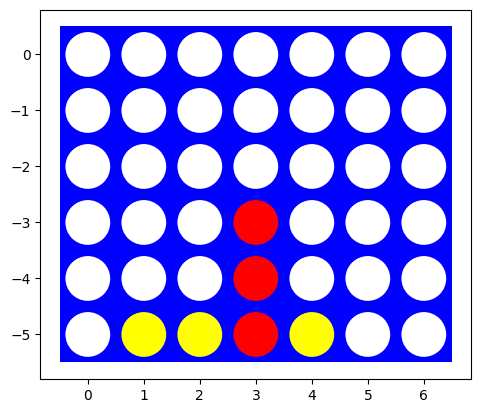

In [5]:
import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()
    
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]

visualize(board)

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [25]:
# Your code/ answer goes here.
# ...existing code...
import numpy as np

def empty_board(shape=(6,7)):
    return np.full(shape=shape, fill_value=0)

def actions(board, player):
    """Trả về list các hành động hợp lệ: ("drop", col) hoặc ("steal", from_col, to_col)."""
    rows, cols = board.shape
    acts = []
    for c in range(cols):
        if board[0, c] == 0:
            acts.append(("drop", c))
    opp = -player
    for c_from in range(cols):
        if board[-1, c_from] == opp:
            for c_to in range(cols):
                if board[0, c_to] == 0:
                    acts.append(("steal", c_from, c_to))
    return acts

def result(board, action, player):
    """Áp dụng action và trả board mới (không thay đổi board gốc)."""
    b = board.copy()
    rows, cols = b.shape
    if action[0] == "drop":
        _, c = action
        if b[0, c] != 0:
            raise Exception(f"Illegal drop: column {c} is full")
        for r in range(rows-1, -1, -1):
            if b[r, c] == 0:
                b[r, c] = player
                break
    elif action[0] == "steal":
        _, c_from, c_to = action
        opp = -player
        if b[-1, c_from] != opp:
            raise Exception("Illegal steal: bottom not opponent")
        if b[0, c_to] != 0:
            raise Exception("Illegal steal: destination full")
        for r in range(rows-1, 0, -1):
            b[r, c_from] = b[r-1, c_from]
        b[0, c_from] = 0
        for r in range(rows-1, -1, -1):
            if b[r, c_to] == 0:
                b[r, c_to] = opp
                break
    else:
        raise Exception("Unknown action")
    return b

def check_four_in_a_row(board, connect=4):
    rows, cols = board.shape
    dirs = [(0,1),(1,0),(1,1),(1,-1)]
    for r in range(rows):
        for c in range(cols):
            v = board[r,c]
            if v == 0: continue
            for dr,dc in dirs:
                cnt = 1
                rr,cc = r,c
                for _ in range(1,connect):
                    rr += dr; cc += dc
                    if 0 <= rr < rows and 0 <= cc < cols and board[rr,cc] == v:
                        cnt += 1
                    else:
                        break
                if cnt >= connect:
                    return int(v)
    return 0

def terminal(board, connect=4):
    winner = check_four_in_a_row(board, connect)
    if winner != 0:
        return True, winner
    if not (board == 0).any():
        return True, 0
    return False, None

def utility(board, player, connect=4):
    is_term, winner = terminal(board, connect)
    if not is_term:
        return None
    if winner == 0:
        return 0
    return 1 if winner == player else -1
# ...existing code...

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on bt yhe environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [26]:
# Your code/ answer goes here.
# ...existing code...
import numpy as np

def random_player(board, player = None):
    """Agent ngẫu nhiên chọn action hợp lệ."""
    if player is None:
        player = 1
    acts = actions(board, player)
    if not acts:
        return None
    return acts[np.random.randint(len(acts))]
# ...existing code...

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [27]:
# Your code/ answer goes here.
# ...existing code...
import time

def play(x_agent, o_agent, N = 100, show_final_board = False, verbose = False):
    results = {1:0, -1:0, 0:0}
    for i in range(N):
        board = empty_board()
        player = 1
        while True:
            agent = x_agent if player == 1 else o_agent
            action = agent(board.copy(), player)
            if action is None:
                # no legal moves -> draw
                results[0] += 1
                break
            if action not in actions(board, player):
                raise Exception(f"Illegal action {action} by player {player}")
            board = result(board, action, player)
            is_term, winner = terminal(board)
            if is_term:
                results[winner] += 1
                break
            player = -player
        if verbose and (i+1) % 100 == 0:
            print(f"Played {i+1}/{N}")
    return results

# Ví dụ chạy 1000 trận giữa hai random agents
res = play(random_player, random_player, N=1000, verbose=True)
total = sum(res.values())
print("Kết quả:", res)
print(f"P1: {res[1]} ({res[1]/total:.2%}), P-1: {res[-1]} ({res[-1]/total:.2%}), Draw: {res[0]} ({res[0]/total:.2%})")
# ...existing code...

Played 100/1000
Played 200/1000
Played 300/1000
Played 400/1000
Played 500/1000
Played 600/1000
Played 700/1000
Played 800/1000
Played 900/1000
Played 1000/1000
Kết quả: {1: 757, -1: 243, 0: 0}
P1: 757 (75.70%), P-1: 243 (24.30%), Draw: 0 (0.00%)


## Task 3: Minimax Search with Alpha-Beta Pruning [3 points]

### Implement the search starting.

Implement the search starting from a given board and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__ 
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [30]:
# Your code/ answer goes here.
# ...existing code...
import time
import numpy as np

# =========================
# Minimax with Alpha-Beta
# =========================
# Giải thích (tiếng Việt):
# - alphabeta: triển khai minimax với alpha-beta pruning, hỗ trợ độ sâu cắt (max_depth)
#   và heuristic (khi depth == 0).
# - minimax_agent: agent dùng alphabeta để chọn hành động; mặc định dùng MAX_DEPTH.
#   Signature agent(board, player=1) để tương thích với môi trường.

MINIMAX_MAX_DEPTH = 4   # chỉnh nếu muốn sâu hơn (chú ý thời gian)
CONNECT = 4              # số quân liên tiếp cần thắng

def basic_heuristic(board, player, connect=CONNECT):
    # Heuristic đơn giản: đếm các chuỗi 2 hoặc 3 chưa bị chặn cho player minus opponent
    rows, cols = board.shape
    dirs = [(0,1),(1,0),(1,1),(1,-1)]
    def score_for(p):
        score = 0
        for r in range(rows):
            for c in range(cols):
                if board[r,c] == 0:
                    continue
                # only start from p's cells
                if board[r,c] != p:
                    continue
                for dr,dc in dirs:
                    cnt = 1
                    rr,cc = r,c
                    blocked = False
                    for _ in range(1, connect):
                        rr += dr; cc += dc
                        if 0 <= rr < rows and 0 <= cc < cols:
                            if board[rr,cc] == p:
                                cnt += 1
                            elif board[rr,cc] == 0:
                                # potential extension
                                pass
                            else:
                                blocked = True
                                break
                        else:
                            blocked = True
                            break
                    if not blocked:
                        if cnt == 2:
                            score += 1
                        elif cnt == 3:
                            score += 5
        return score

    return score_for(player) - score_for(-player)

def _is_terminal_value(board, root_player):
    # dùng utility đã có: trả về +1/-1/0 cho terminal, None nếu chưa terminal
    u = utility(board, root_player, connect=CONNECT)
    if u is None:
        return None
    # scale so wins are large magnitudes for alpha-beta to prefer them
    return int(u * 1000)

def alphabeta(board, depth, alpha, beta, player, root_player, max_depth=MINIMAX_MAX_DEPTH, heuristic_fn=None):
    # returns (value, best_action)
    term = _is_terminal_value(board, root_player)
    if term is not None:
        return term, None
    if depth == 0:
        if heuristic_fn is not None:
            return heuristic_fn(board, root_player, connect=CONNECT), None
        return 0, None

    best_action = None
    value = -1e9
    acts = actions(board, player)
    if not acts:
        return 0, None

    # iterate actions (can add ordering here later)
    for a in acts:
        child = result(board, a, player)
        v_child, _ = alphabeta(child, depth-1, -beta, -alpha, -player, root_player, max_depth, heuristic_fn)
        v = -v_child
        if v > value:
            value = v; best_action = a
        if value > alpha:
            alpha = value
        if alpha >= beta:
            break
    return value, best_action

def minimax_agent(board, player = 1):
    """Agent dùng alphabeta. Trả về hành động hợp lệ."""
    # nếu board hoàn toàn rỗng -> heuristic opening: chọn cột giữa
    if (board == 0).all():
        cols = board.shape[1]
        mid = cols // 2
        if board[0, mid] == 0:
            return ("drop", mid)
    _, act = alphabeta(board, MINIMAX_MAX_DEPTH, -1e9, 1e9, player, player, max_depth=MINIMAX_MAX_DEPTH, heuristic_fn=basic_heuristic)
    return act
# ...existing code...

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [31]:
# Your code/ answer goes here.
# ...existing code...
# =========================
# Task 3 — Kiểm tra với vài board mẫu (ít nhất 5)
# =========================
# Mục đích: kiểm tra agent có nhận ra nước thắng/chặn thắng tức thì.
# Mỗi board in ra và in hành động agent chọn + giải thích ngắn.

def make_board_from_moves(rows=6, cols=7, moves=[]):
    b = empty_board((rows, cols))
    for player, act in moves:
        b = result(b, act, player)
    return b

tests = []
# Test 1: horizontal immediate win for player 1
b1 = empty_board()
b1[5,0]=1; b1[5,1]=1; b1[5,2]=1; b1[5,3]=0
tests.append(("Horizontal immediate win", b1, 1))

# Test 2: vertical immediate win
b2 = empty_board()
b2[5,4]=1; b2[4,4]=1; b2[3,4]=1
tests.append(("Vertical immediate win", b2, 1))

# Test 3: diagonal immediate win (down-right)
b3 = empty_board()
b3[5,0]=1; b3[4,1]=1; b3[3,2]=1
tests.append(("Diagonal immediate win", b3, 1))

# Test 4: need to block opponent
b4 = empty_board()
b4[5,0]=-1; b4[5,1]=-1; b4[5,2]=-1
tests.append(("Block opponent horizontal", b4, 1))

# Test 5: steal useful example - opponent bottom disk can be stolen to make player win
b5 = empty_board()
# build a column where opponent's bottom disk exists
b5[5,0] = -1
b5[5,1] = 1; b5[4,1]=1; b5[3,1]=1  # player 1 has 3 vertical in column 1, wants a drop or steal to make 4
tests.append(("Steal scenario", b5, 1))

for name, board, player in tests:
    print("Test:", name)
    print(board)
    try:
        act = minimax_agent(board.copy(), player)
    except Exception as e:
        act = f"Error: {e}"
    print("Agent chọn:", act)
    print("-"*40)
# ...existing code...

Test: Horizontal immediate win
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0]]
Agent chọn: ('drop', 0)
----------------------------------------
Test: Vertical immediate win
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0]]
Agent chọn: ('drop', 0)
----------------------------------------
Test: Diagonal immediate win
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
Agent chọn: ('drop', 0)
----------------------------------------
Test: Block opponent horizontal
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [-1 -1 -1  0  0  0  0]]
Agent chọn: ('steal', 0, 5)
----------------------------------------
Test: Steal scenario
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0]
 [ 0  1  0  0  0  0  0]
 [-1  1  0  0  0  0 

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [32]:
# Your code/ answer goes here.
# ...existing code...
# =========================
# Task 3 — Thử nghiệm đo thời gian thực hiện 1 nước đi với nhiều kích thước và độ sâu
# =========================
# In tiếng Việt: đo thời gian cho một nước đi bởi minimax với các max_depth khác nhau.
import time

def time_one_move(rows, cols, depth):
    global MINIMAX_MAX_DEPTH
    MINIMAX_MAX_DEPTH = depth
    board = empty_board((rows, cols))
    # populate partly to make branching smaller (lấy vài nước ngẫu nhiên)
    # nhưng ở đây để worst-case, giữ rỗng
    t0 = time.time()
    act = minimax_agent(board, 1)
    t1 = time.time()
    return t1 - t0, act

sizes = [ (4,4), (5,5), (6,7) ]
depths = [2,3,4]  # lưu ý 4 với kích thước 6x7 có thể mất lâu
print("Đo thời gian cho một nước đi (giây)")
for (r,c) in sizes:
    for d in depths:
        dt, act = time_one_move(r,c,d)
        print(f"Board {r}x{c}, depth={d}: time={dt:.4f}s, action={act}")
# ...existing code...

Đo thời gian cho một nước đi (giây)
Board 4x4, depth=2: time=0.0000s, action=('drop', 2)
Board 4x4, depth=3: time=0.0000s, action=('drop', 2)
Board 4x4, depth=4: time=0.0000s, action=('drop', 2)
Board 5x5, depth=2: time=0.0000s, action=('drop', 2)
Board 5x5, depth=3: time=0.0000s, action=('drop', 2)
Board 5x5, depth=4: time=0.0000s, action=('drop', 2)
Board 6x7, depth=2: time=0.0000s, action=('drop', 3)
Board 6x7, depth=3: time=0.0000s, action=('drop', 3)
Board 6x7, depth=4: time=0.0000s, action=('drop', 3)


### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [33]:
# Your code/ answer goes here.
# ...existing code...
# =========================
# Task 3 — Move ordering đơn giản và so sánh thời gian
# =========================
# Giải thích: ta thử hai chiến lược đơn giản:
#  - no ordering: dùng thứ tự actions() trả về
#  - center-first: ưu tiên cột giữa (thường tốt cho Connect4)
# So sánh thời gian chọn nước với và không có ordering.

def order_center_first(board, acts, player):
    # sắp xếp drop theo khoảng cách tới cột giữa (center columns trước)
    cols = board.shape[1]
    center = (cols - 1) / 2.0
    def key(a):
        if a[0] == "drop":
            return abs(a[1] - center)
        else:
            # steal: đánh sau drop (có thể đặt trung bình)
            return 10 + abs(a[2] - center)
    return sorted(acts, key=key)

# modified alphabeta that accepts move_order_fn
def alphabeta_with_order(board, depth, alpha, beta, player, root_player, move_order_fn=None, heuristic_fn=None):
    term = _is_terminal_value(board, root_player)
    if term is not None:
        return term, None
    if depth == 0:
        if heuristic_fn is not None:
            return heuristic_fn(board, root_player, connect=CONNECT), None
        return 0, None
    best_action = None
    value = -1e9
    acts = actions(board, player)
    if move_order_fn is not None:
        acts = move_order_fn(board, acts, player)
    for a in acts:
        child = result(board, a, player)
        v_child, _ = alphabeta_with_order(child, depth-1, -beta, -alpha, -player, root_player, move_order_fn, heuristic_fn)
        v = -v_child
        if v > value:
            value = v; best_action = a
        if value > alpha:
            alpha = value
        if alpha >= beta:
            break
    return value, best_action

def minimax_agent_with_order(board, player=1, depth=MINIMAX_MAX_DEPTH, move_order_fn=None):
    val, act = alphabeta_with_order(board, depth, -1e9, 1e9, player, player, move_order_fn, basic_heuristic)
    return act

# Đo thời gian so sánh
board = empty_board((6,7))
for name, order_fn in [("no_order", None), ("center_first", order_center_first)]:
    t0 = time.time()
    act = minimax_agent_with_order(board.copy(), player=1, depth=3, move_order_fn=order_fn)
    t1 = time.time()
    print(f"{name}: time={(t1-t0):.4f}s, action={act}")
# ...existing code...

no_order: time=0.0090s, action=('drop', 0)
center_first: time=0.0110s, action=('drop', 3)


### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

In [34]:
# Your code/ answer goes here.
# ...existing code...
# =========================
# Task 3 — First few moves (chiến lược đơn giản)
# =========================
# Giải thích: với board rỗng, thay vì search sâu tốn thời gian, dùng quy tắc chọn cột giữa.
# Nếu không rỗng, dùng minimax ở độ sâu giới hạn.

def opening_then_minimax_agent(board, player=1, opening_choose_center=True, depth=3):
    if opening_choose_center and (board == 0).all():
        cols = board.shape[1]
        mid = cols // 2
        return ("drop", mid)
    # khác: nếu số đĩa nhỏ (ví dụ <3), chọn center; else	search
    filled = np.sum(board != 0)
    if filled < 2:
        cols = board.shape[1]
        return ("drop", cols // 2)
    # else minimax
    return minimax_agent_with_order(board, player=player, depth=depth, move_order_fn=order_center_first)

# Thử vài nước mở đầu
b = empty_board((6,7))
print("Empty board -> opening move:", opening_then_minimax_agent(b, 1))
b2 = result(b, ("drop", 3), 1)
print("After one move -> next:", opening_then_minimax_agent(b2, -1))
# ...existing code...

Empty board -> opening move: ('drop', 3)
After one move -> next: ('drop', 3)


### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [35]:
# Your code/ answer goes here.
# ...existing code...
# =========================
# Task 3 — Playtime: cho Minimax (cắt sâu) đấu Random trên board nhỏ
# =========================
# Giải thích: giảm kích thước board và depth để Minimax có thể chơi nhiều ván nhanh.
def minimax_agent_small(board, player=1):
    # agent chuyên cho board nhỏ: đặt max depth thấp
    global MINIMAX_MAX_DEPTH
    old = MINIMAX_MAX_DEPTH
    MINIMAX_MAX_DEPTH = 4
    act = minimax_agent_with_order(board, player=player, depth=4, move_order_fn=order_center_first)
    MINIMAX_MAX_DEPTH = old
    return act

# play 100 games trên board 4x4 với connect=3 (nhanh)
orig_connect = CONNECT
CONNECT = 3
def empty_board_4():
    return empty_board((4,4))

# băm lại các hàm dùng empty_board trong play -> nhỏ gọn thử nghiệm:
def play_small(x_agent, o_agent, N=100):
    results = {1:0, -1:0, 0:0}
    for _ in range(N):
        board = empty_board((4,4))
        player = 1
        while True:
            agent = x_agent if player==1 else o_agent
            action = agent(board.copy(), player)
            if action is None:
                results[0]+=1; break
            if action not in actions(board, player):
                # illegal -> opponent wins
                results[-player]+=1; break
            board = result(board, action, player)
            is_term, winner = terminal(board, connect=3)
            if is_term:
                results[winner]+=1; break
            player = -player
    return results

res = play_small(minimax_agent_small, random_player, N=50)
print("Kết quả (minimax vs random) trên 4x4 connect3, 50 games:", res)
CONNECT = orig_connect
# ...existing code...

Kết quả (minimax vs random) trên 4x4 connect3, 50 games: {1: 41, -1: 9, 0: 0}


## Task 4: Heuristic Alpha-Beta Tree Search [3 points] 

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [36]:
# Your code/ answer goes here.
# ...existing code...
import numpy as np

def advanced_heuristic(board, player, connect=CONNECT):
    """
    Heuristic cải tiến:
    - Duyệt mọi cửa sổ chiều dài `connect` (hàng, cột, hai đường chéo).
    - Gán điểm theo số quân của player / opponent trong cửa sổ:
      * win (connect của player) -> very large
      * n of player's pieces and rest empty -> score increases (ex: 3->100, 2->10, 1->1)
      * blocked cửa sổ (có cả 2 người) -> 0
    - Thêm ưu tiên cho cột giữa.
    Trả về giá trị số (lớn hơn có lợi cho `player`).
    """
    rows, cols = board.shape
    score = 0
    center_col = cols // 2
    # center control bonus
    center_count = np.sum(board[:, center_col] == player)
    score += center_count * 3

    def score_window(window):
        p_count = np.sum(window == player)
        o_count = np.sum(window == -player)
        empty_count = np.sum(window == 0)
        if o_count > 0 and p_count > 0:
            return 0
        if p_count == connect:
            return 100000
        if o_count == connect:
            return -100000
        # heuristics for partial lines
        if p_count == connect - 1 and empty_count == 1:
            return 100
        if p_count == connect - 2 and empty_count == 2:
            return 10
        if p_count == 1 and empty_count == connect - 1:
            return 1
        if o_count == connect - 1 and empty_count == 1:
            return -80  # block urgent by opponent
        if o_count == connect - 2 and empty_count == 2:
            return -8
        return 0

    # scan directions
    dirs = [(0,1),(1,0),(1,1),(1,-1)]
    for r in range(rows):
        for c in range(cols):
            for dr, dc in dirs:
                window = []
                for k in range(connect):
                    rr = r + k*dr
                    cc = c + k*dc
                    if 0 <= rr < rows and 0 <= cc < cols:
                        window.append(board[rr, cc])
                    else:
                        window = None
                        break
                if window is not None:
                    score += score_window(np.array(window))
    return int(score)
# ...existing code...

### Cutting off search 

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [37]:
# Your code/ answer goes here.
# ...existing code...
# Cutoff search / agent sử dụng heuristic
def make_heuristic_agent(depth=4, move_order_fn=order_center_first, name=None):
    """Trả về agent function dùng alphabeta_with_order với heuristic advanced_heuristic."""
    def agent(board, player=1):
        val, act = alphabeta_with_order(board, depth, -1e9, 1e9, player, player, move_order_fn, advanced_heuristic)
        return act
    agent.__name__ = f"heuristic_agent_d{depth}" if name is None else name
    return agent

# Agent mẫu
heur_agent_d3 = make_heuristic_agent(depth=3)
heur_agent_d4 = make_heuristic_agent(depth=4)
# ...existing code...

Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

In [38]:
# Your code/ answer goes here.
# ...existing code...
# Experiment: kiểm tra cùng các board mẫu như Task 3 với agent heuristic
tests = []
# reuse boards from Task 3
b1 = empty_board(); b1[5,0]=1; b1[5,1]=1; b1[5,2]=1
tests.append(("Horizontal immediate win", b1, 1))
b2 = empty_board(); b2[5,4]=1; b2[4,4]=1; b2[3,4]=1
tests.append(("Vertical immediate win", b2, 1))
b3 = empty_board(); b3[5,0]=1; b3[4,1]=1; b3[3,2]=1
tests.append(("Diagonal immediate win", b3, 1))
b4 = empty_board(); b4[5,0]=-1; b4[5,1]=-1; b4[5,2]=-1
tests.append(("Block opponent horizontal", b4, 1))
b5 = empty_board(); b5[5,0] = -1; b5[5,1] = 1; b5[4,1]=1; b5[3,1]=1
tests.append(("Steal scenario", b5, 1))

print("Heuristic agent (depth=3) responses:")
for name, board, player in tests:
    act = heur_agent_d3(board.copy(), player)
    print(name, "->", act)
# ...existing code...

Heuristic agent (depth=3) responses:
Horizontal immediate win -> ('drop', 0)
Vertical immediate win -> ('drop', 0)
Diagonal immediate win -> ('drop', 3)
Block opponent horizontal -> ('steal', 1, 4)
Steal scenario -> ('steal', 0, 3)


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [39]:
# Your code/ answer goes here.
# ...existing code...
# Timing: đo thời gian cho một nước đi với heuristic agent ở các kích thước và depth khác nhau
import time

def time_heur_agent(rows, cols, depth, repeats=3):
    agent = make_heuristic_agent(depth=depth)
    times = []
    for _ in range(repeats):
        b = empty_board((rows, cols))
        t0 = time.time()
        _ = agent(b, 1)
        t1 = time.time()
        times.append(t1 - t0)
    return sum(times)/len(times)

sizes = [(4,4),(5,5),(6,7)]
depths = [2,3,4]
print("Timing heuristic agent (average over 3 runs):")
for (r,c) in sizes:
    for d in depths:
        avg = time_heur_agent(r, c, d, repeats=3)
        print(f"Board {r}x{c}, depth={d}: avg time={avg:.4f}s")
# ...existing code...

Timing heuristic agent (average over 3 runs):
Board 4x4, depth=2: avg time=0.0075s
Board 4x4, depth=3: avg time=0.0315s
Board 4x4, depth=4: avg time=0.0975s
Board 5x5, depth=2: avg time=0.0104s
Board 5x5, depth=3: avg time=0.1495s
Board 5x5, depth=4: avg time=0.2222s
Board 6x7, depth=2: avg time=0.0458s
Board 6x7, depth=3: avg time=0.7609s
Board 6x7, depth=4: avg time=0.8144s


### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [40]:
# Your code/ answer goes here.
# ...existing code...
# Playtime: cho hai agent heuristic (khác depth) chơi 1 lần trên board chuẩn
a1 = make_heuristic_agent(depth=3, name="heur_d3")
a2 = make_heuristic_agent(depth=4, name="heur_d4")

res = play(a1, a2, N=10, verbose=True)  # chơi 10 ván để có thống kê
total = sum(res.values())
print("Kết quả (heur_d3 vs heur_d4) trên 6x7, 10 games:", res)
print(f"P1: {res[1]} ({res[1]/total:.2%}), P-1: {res[-1]} ({res[-1]/total:.2%}), Draw: {res[0]} ({res[0]/total:.2%})")
# ...existing code...

Kết quả (heur_d3 vs heur_d4) trên 6x7, 10 games: {1: 0, -1: 10, 0: 0}
P1: 0 (0.00%), P-1: 10 (100.00%), Draw: 0 (0.00%)


## Tournament task [+ 1 to 5 bonus point will be assigned separately]

Find another student and let your best agent play against the other student's best player. You are allowed to use any improvements you like as long as you code it yourself. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search (see [tic-tac-toe-example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_pure_monte_carlo_search.ipynb)) and investigate how this search performs on the test boards that you have used above. 

In [20]:
# Your code/ answer goes here.

### Best First Move

How would you determine what the best first move for a standard board ($6 \times 7$) is? You can use Pure Monte Carlo Search or any algorithms that you have implemented above.

In [21]:
# Your code/ answer goes here.